In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection as modsel
import sklearn.preprocessing as preproc

## Load and prep Yelp reviews data

In [2]:
## Load Yelp Business data
biz_f = open('data/yelp/v6/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.json')
biz_df = pd.DataFrame([json.loads(x) for x in biz_f.readlines()])
biz_f.close()

## Load Yelp Reviews data
review_file = open('data/yelp/v6/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json')
review_df = pd.DataFrame([json.loads(x) for x in review_file.readlines()])
review_file.close()

In [ ]:
biz_df.shape

In [ ]:
review_df.shape

In [3]:
# Pull out only Nightlife and Restaurants businesses
two_biz = biz_df[biz_df.apply(lambda x: 'Nightlife' in x['categories'] 
                                        or 'Restaurants' in x['categories'], 
                              axis=1)]

In [4]:
two_biz.shape

(24187, 15)

In [5]:
biz_df.shape

(61184, 15)

In [6]:
## Join with the reviews to get all reviews on the two types of business
twobiz_reviews = two_biz.merge(review_df, on='business_id', how='inner')

In [7]:
twobiz_reviews.shape

(1061863, 22)

In [31]:
twobiz_reviews.to_pickle('data/yelp/v6/yelp_dataset_challenge_academic_dataset/twobiz_reviews.pkl')

In [8]:
twobiz_reviews = pd.read_pickle('data/yelp/v6/yelp_dataset_challenge_academic_dataset/twobiz_reviews.pkl')

In [8]:
# Trim away the features we won't use
twobiz_reviews = twobiz_reviews[['business_id', 
                                 'name', 
                                 'stars_y', 
                                 'text', 
                                 'categories']]

In [9]:
# Create the target column--True for Nightlife businesses, and False otherwise
twobiz_reviews['target'] = twobiz_reviews.apply(lambda x: 'Nightlife' in x['categories'],
                                                axis=1)

In [16]:
## Now pull out each class of reviews separately, 
## so we can create class-balanced samples for training
nightlife = twobiz_reviews[twobiz_reviews.apply(lambda x: 'Nightlife' in x['categories'], axis=1)]
restaurants = twobiz_reviews[twobiz_reviews.apply(lambda x: 'Restaurants' in x['categories'], axis=1)]


In [17]:
nightlife.shape

(210028, 5)

In [18]:
restaurants.shape

(990627, 5)

In [34]:
nightlife_subset = nightlife.sample(frac=0.1, random_state=123)
restaurant_subset = restaurants.sample(frac=0.021, random_state=123)

In [35]:
nightlife_subset.shape

(21003, 5)

In [36]:
restaurant_subset.shape

(20803, 5)

In [37]:
nightlife_subset.to_pickle('data/yelp/v6/yelp_dataset_challenge_academic_dataset/nightlife_subset.pkl')
restaurant_subset.to_pickle('data/yelp/v6/yelp_dataset_challenge_academic_dataset/restaurant_subset.pkl')

In [2]:
nightlife_subset = pd.read_pickle('data/yelp/v6/yelp_dataset_challenge_academic_dataset/nightlife_subset.pkl')
restaurant_subset = pd.read_pickle('data/yelp/v6/yelp_dataset_challenge_academic_dataset/restaurant_subset.pkl')

In [3]:
combined = pd.concat([nightlife_subset, restaurant_subset])

In [4]:
combined['target'] = combined.apply(lambda x: 'Nightlife' in x['categories'],
                                    axis=1)

In [5]:
combined

,business_id,name,stars_y,text,categories,target
223202,aRkYtXfmEKYG-eTDf_qUsw,Lux,5,You have to try the velvet!!! Lux is so to die...,"[Coffee & Tea, Food, Bars, Nightlife, American...",True
365597,k-D2NUfaUbuQzPaMXniXcA,The Pub at Monte Carlo,3,This joint is hit or miss on the nite scene......,"[Pubs, Bars, American (Traditional), Nightlife...",True
399883,adv1-kA6k2N4L-e4zULuNg,Fremont Street Experience,5,"it's always fun to ""people watch"" on fremont c...","[Casinos, Bars, Arts & Entertainment, Nightlife]",True
175018,_F2DNPjsqgkAd50zuX8dYQ,Harold's Corral,2,Went for another try at Sunday Brunch. First o...,"[American (Traditional), Steakhouses, Nightlif...",True
647870,tLLz1fzVjG84LF-mv9hAEw,Mandarin Bar,5,I like and probably prefer a dive bar over hig...,"[Bars, Nightlife, Lounges]",True
1058274,YYM9p7iV3A3dGtsqjemqBw,Echo 5 Sports Pub,5,"What a great find! Service was awesome, food w...","[Bars, Restaurants, American (Traditional), Sp...",True
538477,4xqn5hGqXKcU7_pY5lKYOQ,Hawthorne's NY Pizza & Bar,2,"went there for ""the best in pizza in Charlotte...","[Italian, Bars, Pizza, Nightlife, Restaurants]",True
26030,IgaruuknYwCr9afeDYQ_yw,Dirty Drummer,4,A clean dive bar neatly disguised as a sports ...,"[Nightlife, Restaurants]",True
606932,3n9mSKySEv3G03YjcU-YOQ,Postino Central,5,This is my new favorite restaurant in Phoenix....,"[Bars, Breakfast & Brunch, Wine Bars, Nightlif...",True
125852,LLR8iqKn7nmfwXWl1S13Lw,Hawk's Bar & Grill,4,"Med plate is great, price is fair. Even the sm...","[Bars, Restaurants, American (Traditional), Sp...",True


In [6]:
# Split into training and test data sets
training_data, test_data = modsel.train_test_split(combined, 
                                                   train_size=0.7, 
                                                   random_state=123)

C:\Users\Lemon\Anaconda3\envs\mfe\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
training_data.shape

(29264, 6)

In [8]:
test_data.shape

(12542, 6)

In [9]:
# Represent the review text as a bag-of-words 
bow_transform = text.CountVectorizer()
X_tr_bow = bow_transform.fit_transform(training_data['text'])

In [10]:
len(bow_transform.vocabulary_)

46924

In [11]:
X_tr_bow.shape

(29264, 46924)

In [12]:
X_te_bow = bow_transform.transform(test_data['text'])

In [13]:
y_tr = training_data['target']
y_te = test_data['target']

In [14]:
# Create the tf-idf representation using the bag-of-words matrix
tfidf_trfm = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_trfm.fit_transform(X_tr_bow)

In [15]:
X_te_tfidf = tfidf_trfm.transform(X_te_bow)

In [16]:
X_tr_l2 = preproc.normalize(X_tr_bow, axis=0)
X_te_l2 = preproc.normalize(X_te_bow, axis=0)

## Classify with logistic regression

In [33]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    ## Helper function to train a logistic classifier and score on test data
    m = LogisticRegression(C=_C).fit(X_tr, y_tr)
    s = m.score(X_test, y_test)
    print ('Test score with', description, 'features:', s)
    return m

In [21]:
m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized')
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test score with bow features: 0.775873066497
Test score with l2-normalized features: 0.763514590974
Test score with tf-idf features: 0.743182905438


## Tune regularization parameters using grid search

In [21]:
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
bow_search = modsel.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
l2_search = modsel.GridSearchCV(LogisticRegression(), cv=5,
                               param_grid=param_grid_)
tfidf_search = modsel.GridSearchCV(LogisticRegression(), cv=5,
                                   param_grid=param_grid_)

In [22]:
bow_search.fit(X_tr_bow, y_tr)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [23]:
bow_search.best_score_

0.78283898305084743

In [24]:
l2_search.fit(X_tr_l2, y_tr)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [25]:
l2_search.best_score_

0.77675642427556046

In [26]:
tfidf_search.fit(X_tr_tfidf, y_tr)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [27]:
tfidf_search.best_score_

0.78864816839803176

In [28]:
bow_search.best_params_

{'C': 0.1}

In [29]:
l2_search.best_params_

{'C': 10.0}

In [30]:
tfidf_search.best_params_

{'C': 0.001}

In [32]:
bow_search.cv_results_

{'mean_fit_time': array([  0.43648252,   0.94630651,   5.64090128,  15.31248307,
         31.47010217,  42.44257565]),
 'mean_score_time': array([ 0.00080056,  0.00392466,  0.00864897,  0.00784755,  0.01192751,
         0.0072515 ]),
 'mean_test_score': array([ 0.57897075,  0.7518111 ,  0.78283898,  0.77381766,  0.75515992,
         0.73937261]),
 'mean_train_score': array([ 0.5792185 ,  0.76731652,  0.87697341,  0.94629064,  0.98357195,
         0.99441294]),
 'param_C': masked_array(data = [1e-05 0.001 0.1 1.0 10.0 100.0],
              mask = [False False False False False False],
        fill_value = ?),
 'params': ({'C': 1e-05},
  {'C': 0.001},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0}),
 'rank_test_score': array([6, 4, 1, 2, 3, 5]),
 'split0_test_score': array([ 0.58028698,  0.75025624,  0.7799795 ,  0.7726341 ,  0.75247694,
         0.74086095]),
 'split0_train_score': array([ 0.57923964,  0.76860316,  0.87560871,  0.94434003,  0.9819308 ,
         0.99470312]),


In [17]:
import pickle

In [35]:
results_file = open('tfidf_gridcv_results.pkl', 'wb')
pickle.dump(bow_search, results_file, -1)
pickle.dump(tfidf_search, results_file, -1)
pickle.dump(l2_search, results_file, -1)
results_file.close()

In [18]:
pkl_file = open('tfidf_gridcv_results.pkl', 'rb')
bow_search = pickle.load(pkl_file)
tfidf_search = pickle.load(pkl_file)
l2_search = pickle.load(pkl_file)
pkl_file.close()

C:\Users\Lemon\Anaconda3\envs\mfe\lib\site-packages\sklearn\base.py:312: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.18.2 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Lemon\Anaconda3\envs\mfe\lib\site-packages\sklearn\base.py:312: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.18.2 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [19]:
search_results = pd.DataFrame.from_dict({'bow': bow_search.cv_results_['mean_test_score'],
                               'tfidf': tfidf_search.cv_results_['mean_test_score'],
                               'l2': l2_search.cv_results_['mean_test_score']})
search_results

,bow,l2,tfidf
0,0.578971,0.575724,0.721638
1,0.751811,0.575724,0.788648
2,0.782839,0.589120,0.763566
3,0.773818,0.734247,0.741150
4,0.755160,0.776756,0.721467
5,0.739373,0.761106,0.712309


## Plot cross validation results

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

C:\Users\Lemon\Anaconda3\envs\mfe\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


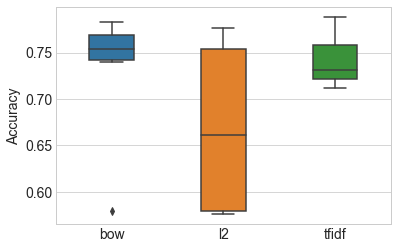

In [27]:
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=14)
plt.savefig('tfidf_gridcv_results.png')

In [35]:
m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow', 
                              _C=bow_search.best_params_['C'])
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized', 
                              _C=l2_search.best_params_['C'])
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf', 
                              _C=tfidf_search.best_params_['C'])

Test score with bow features: 0.78360708021
Test score with l2-normalized features: 0.780178599904
Test score with tf-idf features: 0.788470738319


In [43]:
bow_search.cv_results_['mean_test_score']

array([ 0.57897075,  0.7518111 ,  0.78283898,  0.77381766,  0.75515992,
        0.73937261])